Skip-gram word2vec:  
https://github.com/mchablani/deep-learning/blob/master/embeddings/Skip-Gram_word2vec.ipynb 

In [1]:
import time

import numpy as np
import tensorflow as tf

import utils

/Users/unahsu/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from process_data import make_dir, download, read_data, build_vocab, convert_words_to_index, process_data, generate_sample, get_batch, get_batch_gen

vocab_size = 10000
window_sz = 5
batch_sz = 64

index_words, dictionary, index_dictionary = process_data(vocab_size)
batch_gen = get_batch_gen(index_words, window_sz, batch_sz)
X, y = next(batch_gen) #X=center, y=neighbor(number of neighbor is random(1~5) )

print(X.shape)
print(y.shape)

Dataset ready
(64,)
(64, 1)


### Building the graph

In [3]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')

### Embedding

In [4]:
n_vocab = len(dictionary)
n_embedding =  128

with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs) # use tf.nn.embedding_lookup to get the hidden layer output


### Negative sampling

In [5]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding))) # (10000X300)create softmax weight matrix here
    softmax_b = tf.Variable(tf.zeros(n_vocab), name="softmax_bias") # create softmax biases here

    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(
        weights=softmax_w,
        biases=softmax_b,
        labels=labels,
        inputs=embed,
        num_sampled=n_sampled,
        num_classes=n_vocab)

    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

### Validation

In [6]:
import random

with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [7]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

mkdir: checkpoints: File exists


### Training

In [8]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''

    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx+1:stop+1])

    return list(target_words)

def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''

    n_batches = len(words)//batch_size

    # only full batches
    words = words[ :n_batches*batch_size]

    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

In [9]:
epochs = 10
batch_size = 1000
window_size = 5

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(index_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:

            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)

            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()

            if iteration % 1000 == 0:
                ## From Thushan Ganegedara's implementation
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = index_dictionary[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = index_dictionary[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)


Epoch 1/10 Iteration: 100 Avg. Training loss: 15.7813 0.0865 sec/batch
Epoch 1/10 Iteration: 200 Avg. Training loss: 14.9820 0.0824 sec/batch
Epoch 1/10 Iteration: 300 Avg. Training loss: 14.0716 0.0760 sec/batch
Epoch 1/10 Iteration: 400 Avg. Training loss: 13.4099 0.0734 sec/batch
Epoch 1/10 Iteration: 500 Avg. Training loss: 12.8676 0.0803 sec/batch
Epoch 1/10 Iteration: 600 Avg. Training loss: 11.9998 0.0703 sec/batch
Epoch 1/10 Iteration: 700 Avg. Training loss: 11.7526 0.0754 sec/batch
Epoch 1/10 Iteration: 800 Avg. Training loss: 11.0329 0.0798 sec/batch
Epoch 1/10 Iteration: 900 Avg. Training loss: 10.5593 0.0849 sec/batch
Epoch 1/10 Iteration: 1000 Avg. Training loss: 9.9926 0.0826 sec/batch
Nearest to four: classic, save, births, prophets, sketches, late, actress, table,
Nearest to will: parish, reply, sentenced, partial, formed, dam, inclined, capita,
Nearest to zero: garden, his, sailors, kinds, massachusetts, designed, holidays, frequently,
Nearest to who: facilities, fulf

Epoch 1/10 Iteration: 4100 Avg. Training loss: 6.0496 0.0721 sec/batch
Epoch 1/10 Iteration: 4200 Avg. Training loss: 5.8264 0.0680 sec/batch
Epoch 1/10 Iteration: 4300 Avg. Training loss: 5.8868 0.0679 sec/batch
Epoch 1/10 Iteration: 4400 Avg. Training loss: 5.8667 0.0688 sec/batch
Epoch 1/10 Iteration: 4500 Avg. Training loss: 5.6460 0.0682 sec/batch
Epoch 1/10 Iteration: 4600 Avg. Training loss: 5.6662 0.0686 sec/batch
Epoch 1/10 Iteration: 4700 Avg. Training loss: 5.7594 0.0696 sec/batch
Epoch 1/10 Iteration: 4800 Avg. Training loss: 5.6100 0.0724 sec/batch
Epoch 1/10 Iteration: 4900 Avg. Training loss: 5.5714 0.0744 sec/batch
Epoch 1/10 Iteration: 5000 Avg. Training loss: 5.4718 0.0695 sec/batch
Nearest to four: five, in, late, three, at, births, and, one,
Nearest to will: can, but, so, before, his, was, as, are,
Nearest to zero: more, UNK, from, on, his, with, in, and,
Nearest to who: that, and, by, for, in, some, also, UNK,
Nearest to state: is, overcome, appear, working, when, 

Epoch 1/10 Iteration: 8900 Avg. Training loss: 4.7528 0.0720 sec/batch
Epoch 1/10 Iteration: 9000 Avg. Training loss: 4.9544 0.0746 sec/batch
Nearest to four: five, three, one, two, nine, six, zero, seven,
Nearest to will: would, can, to, may, could, but, that, is,
Nearest to zero: two, five, three, four, nine, one, eight, seven,
Nearest to who: by, which, that, only, to, and, while, but,
Nearest to state: of, the, from, in, part, within, a, its,
Nearest to use: some, any, many, which, or, all, a, an,
Nearest to d: UNK, three, seven, one, john, nine, original, two,
Nearest to called: or, which, a, by, for, used, an, that,
Nearest to governor: speakers, elsewhere, critical, on, dawn, traditionally, second, site,
Nearest to running: single, zones, popular, closed, journal, phi, large, advantages,
Nearest to additional: subject, zealand, just, an, form, because, apply, name,
Nearest to notes: six, mazda, contexts, official, queen, cricket, vehicle, s,
Nearest to except: often, generally, 

Epoch 1/10 Iteration: 13100 Avg. Training loss: 4.2548 0.0699 sec/batch
Epoch 1/10 Iteration: 13200 Avg. Training loss: 4.3688 0.0687 sec/batch
Epoch 1/10 Iteration: 13300 Avg. Training loss: 4.4051 0.0683 sec/batch
Epoch 1/10 Iteration: 13400 Avg. Training loss: 4.4458 0.0688 sec/batch
Epoch 1/10 Iteration: 13500 Avg. Training loss: 4.3810 0.0708 sec/batch
Epoch 1/10 Iteration: 13600 Avg. Training loss: 4.4635 0.0689 sec/batch
Epoch 1/10 Iteration: 13700 Avg. Training loss: 4.5077 0.0688 sec/batch
Epoch 1/10 Iteration: 13800 Avg. Training loss: 4.4447 0.0693 sec/batch
Epoch 1/10 Iteration: 13900 Avg. Training loss: 4.3998 0.0681 sec/batch
Epoch 1/10 Iteration: 14000 Avg. Training loss: 4.4447 0.0680 sec/batch
Nearest to four: five, three, six, seven, eight, one, nine, two,
Nearest to will: would, could, can, must, should, might, to, may,
Nearest to zero: two, five, three, four, six, one, seven, eight,
Nearest to who: by, then, he, while, never, him, later, when,
Nearest to state: hist

Epoch 2/10 Iteration: 18100 Avg. Training loss: 4.1767 0.0682 sec/batch
Epoch 2/10 Iteration: 18200 Avg. Training loss: 4.2271 0.0689 sec/batch
Epoch 2/10 Iteration: 18300 Avg. Training loss: 4.3780 0.0687 sec/batch
Epoch 2/10 Iteration: 18400 Avg. Training loss: 4.3136 0.0688 sec/batch
Epoch 2/10 Iteration: 18500 Avg. Training loss: 4.3398 0.0688 sec/batch
Epoch 2/10 Iteration: 18600 Avg. Training loss: 4.2935 0.0679 sec/batch
Epoch 2/10 Iteration: 18700 Avg. Training loss: 4.2866 0.0681 sec/batch
Epoch 2/10 Iteration: 18800 Avg. Training loss: 4.3004 0.0680 sec/batch
Epoch 2/10 Iteration: 18900 Avg. Training loss: 4.2099 0.0676 sec/batch
Epoch 2/10 Iteration: 19000 Avg. Training loss: 4.3333 0.0687 sec/batch
Nearest to four: six, five, three, eight, seven, one, two, nine,
Nearest to will: would, must, could, cannot, can, might, should, may,
Nearest to zero: two, five, three, four, six, one, eight, seven,
Nearest to who: he, whom, she, him, never, by, himself, already,
Nearest to stat

Epoch 2/10 Iteration: 23000 Avg. Training loss: 4.2753 0.0681 sec/batch
Nearest to four: five, six, three, seven, two, eight, one, zero,
Nearest to will: would, could, must, might, cannot, should, can, may,
Nearest to zero: five, two, three, four, six, seven, one, eight,
Nearest to who: whom, him, he, himself, never, she, killed, young,
Nearest to state: city, community, nation, university, government, national, district, college,
Nearest to use: specific, certain, terms, instead, some, allow, changes, process,
Nearest to d: c, b, j, l, v, r, g, m,
Nearest to called: considered, UNK, or, simply, produced, usually, using, given,
Nearest to governor: president, appointed, chief, former, secretary, council, henry, leader,
Nearest to running: run, single, up, line, moving, placed, onto, back,
Nearest to additional: data, or, using, specific, problems, extra, use, usually,
Nearest to notes: UNK, version, original, references, history, site, magazine, and,
Nearest to except: only, all, while

Epoch 2/10 Iteration: 27100 Avg. Training loss: 4.2375 0.0682 sec/batch
Epoch 2/10 Iteration: 27200 Avg. Training loss: 4.2202 0.0704 sec/batch
Epoch 2/10 Iteration: 27300 Avg. Training loss: 4.2485 0.0704 sec/batch
Epoch 2/10 Iteration: 27400 Avg. Training loss: 4.2129 0.0735 sec/batch
Epoch 2/10 Iteration: 27500 Avg. Training loss: 4.2244 0.0688 sec/batch
Epoch 2/10 Iteration: 27600 Avg. Training loss: 4.1724 0.0681 sec/batch
Epoch 2/10 Iteration: 27700 Avg. Training loss: 4.2242 0.0686 sec/batch
Epoch 2/10 Iteration: 27800 Avg. Training loss: 4.2534 0.0686 sec/batch
Epoch 2/10 Iteration: 27900 Avg. Training loss: 4.2400 0.0688 sec/batch
Epoch 2/10 Iteration: 28000 Avg. Training loss: 4.2437 0.0687 sec/batch
Nearest to four: six, five, three, seven, eight, two, one, zero,
Nearest to will: must, could, would, cannot, can, should, might, may,
Nearest to zero: five, two, four, three, six, seven, eight, one,
Nearest to who: whom, young, him, he, himself, she, killed, felt,
Nearest to sta

Epoch 2/10 Iteration: 31500 Avg. Training loss: 4.2410 0.0688 sec/batch
Epoch 2/10 Iteration: 31600 Avg. Training loss: 4.2149 0.0703 sec/batch
Epoch 2/10 Iteration: 31700 Avg. Training loss: 4.1897 0.0699 sec/batch
Epoch 2/10 Iteration: 31800 Avg. Training loss: 4.1693 0.0680 sec/batch
Epoch 2/10 Iteration: 31900 Avg. Training loss: 4.1987 0.0708 sec/batch
Epoch 2/10 Iteration: 32000 Avg. Training loss: 4.1861 0.0687 sec/batch
Nearest to four: five, six, three, seven, eight, two, one, nine,
Nearest to will: would, could, must, cannot, might, can, may, should,
Nearest to zero: two, five, four, three, six, seven, one, eight,
Nearest to who: whom, young, him, himself, reportedly, never, he, children,
Nearest to state: nation, national, government, city, department, council, states, federal,
Nearest to use: specific, allow, specifically, provide, need, certain, some, application,
Nearest to d: b, j, c, r, l, k, UNK, o,
Nearest to called: UNK, pronounced, etc, here, used, image, now, or,
N

Epoch 3/10 Iteration: 35800 Avg. Training loss: 4.1424 0.0689 sec/batch
Epoch 3/10 Iteration: 35900 Avg. Training loss: 4.0937 0.0676 sec/batch
Epoch 3/10 Iteration: 36000 Avg. Training loss: 4.1774 0.0684 sec/batch
Nearest to four: six, five, three, seven, eight, two, one, nine,
Nearest to will: would, could, must, might, cannot, can, should, may,
Nearest to zero: two, five, three, four, six, seven, eight, one,
Nearest to who: whom, young, him, himself, she, he, men, them,
Nearest to state: district, city, states, nation, territory, county, department, national,
Nearest to use: allow, used, using, specific, applications, require, support, need,
Nearest to d: b, richard, french, robert, seven, eight, nine, writer,
Nearest to called: considered, termed, UNK, used, referred, pronounced, named, sometimes,
Nearest to governor: appointed, president, secretary, former, chief, council, territory, supreme,
Nearest to running: run, straight, runs, moving, line, track, cut, released,
Nearest to 

Epoch 3/10 Iteration: 40100 Avg. Training loss: 4.1922 0.0690 sec/batch
Epoch 3/10 Iteration: 40200 Avg. Training loss: 4.2080 0.0690 sec/batch
Epoch 3/10 Iteration: 40300 Avg. Training loss: 4.1145 0.0688 sec/batch
Epoch 3/10 Iteration: 40400 Avg. Training loss: 4.1545 0.0687 sec/batch
Epoch 3/10 Iteration: 40500 Avg. Training loss: 4.1810 0.0688 sec/batch
Epoch 3/10 Iteration: 40600 Avg. Training loss: 4.0887 0.0689 sec/batch
Epoch 3/10 Iteration: 40700 Avg. Training loss: 4.1483 0.0689 sec/batch
Epoch 3/10 Iteration: 40800 Avg. Training loss: 4.1773 0.0682 sec/batch
Epoch 3/10 Iteration: 40900 Avg. Training loss: 4.1476 0.0690 sec/batch
Epoch 3/10 Iteration: 41000 Avg. Training loss: 4.1247 0.0687 sec/batch
Nearest to four: six, five, three, seven, eight, one, two, nine,
Nearest to will: would, could, must, can, might, cannot, should, need,
Nearest to zero: five, two, four, three, six, seven, eight, one,
Nearest to who: whom, fellow, young, him, himself, reportedly, she, men,
Neares

Epoch 3/10 Iteration: 44400 Avg. Training loss: 4.1357 0.0686 sec/batch
Epoch 3/10 Iteration: 44500 Avg. Training loss: 4.1474 0.0683 sec/batch
Epoch 3/10 Iteration: 44600 Avg. Training loss: 4.1007 0.0686 sec/batch
Epoch 3/10 Iteration: 44700 Avg. Training loss: 4.1641 0.0689 sec/batch
Epoch 3/10 Iteration: 44800 Avg. Training loss: 4.1744 0.0692 sec/batch
Epoch 3/10 Iteration: 44900 Avg. Training loss: 4.1559 0.0687 sec/batch
Epoch 3/10 Iteration: 45000 Avg. Training loss: 4.1765 0.0691 sec/batch
Nearest to four: six, five, three, seven, eight, two, one, nine,
Nearest to will: could, would, must, cannot, can, should, might, may,
Nearest to zero: five, two, four, three, six, seven, one, eight,
Nearest to who: whom, young, fellow, parents, followers, him, herself, themselves,
Nearest to state: nation, government, legislature, offices, representative, governor, district, council,
Nearest to use: allow, usage, specifically, used, specific, offer, content, applications,
Nearest to d: b, c

Epoch 3/10 Iteration: 48500 Avg. Training loss: 4.1874 0.0690 sec/batch
Epoch 3/10 Iteration: 48600 Avg. Training loss: 4.1622 0.0679 sec/batch
Epoch 3/10 Iteration: 48700 Avg. Training loss: 4.1320 0.0679 sec/batch
Epoch 3/10 Iteration: 48800 Avg. Training loss: 4.1031 0.0673 sec/batch
Epoch 3/10 Iteration: 48900 Avg. Training loss: 4.1530 0.0683 sec/batch
Epoch 3/10 Iteration: 49000 Avg. Training loss: 4.1257 0.0676 sec/batch
Nearest to four: five, six, three, seven, eight, two, one, nine,
Nearest to will: would, must, could, might, can, cannot, may, shall,
Nearest to zero: five, two, four, three, six, seven, eight, one,
Nearest to who: whom, young, fellow, him, reportedly, parents, themselves, himself,
Nearest to state: nation, department, legislature, government, city, states, county, institution,
Nearest to use: using, provide, allow, used, specifically, make, need, represent,
Nearest to d: b, c, j, l, g, k, r, UNK,
Nearest to called: termed, UNK, used, pronounced, named, uses, im

Epoch 4/10 Iteration: 52600 Avg. Training loss: 4.1032 0.0691 sec/batch
Epoch 4/10 Iteration: 52700 Avg. Training loss: 4.0800 0.0701 sec/batch
Epoch 4/10 Iteration: 52800 Avg. Training loss: 4.0968 0.0699 sec/batch
Epoch 4/10 Iteration: 52900 Avg. Training loss: 4.0653 0.0703 sec/batch
Epoch 4/10 Iteration: 53000 Avg. Training loss: 4.1305 0.0691 sec/batch
Nearest to four: six, three, five, seven, eight, two, one, nine,
Nearest to will: would, must, could, might, can, cannot, should, shall,
Nearest to zero: five, two, six, three, four, seven, eight, one,
Nearest to who: whom, young, fellow, him, father, them, personally, parents,
Nearest to state: district, city, institution, department, michigan, states, legislature, county,
Nearest to use: used, usage, allow, support, using, application, specifically, provide,
Nearest to d: b, richard, robert, nine, c, eight, seven, j,
Nearest to called: termed, named, used, considered, UNK, referred, spelled, known,
Nearest to governor: lieutenant,

Epoch 4/10 Iteration: 56800 Avg. Training loss: 4.1365 0.0692 sec/batch
Epoch 4/10 Iteration: 56900 Avg. Training loss: 4.1472 0.0698 sec/batch
Epoch 4/10 Iteration: 57000 Avg. Training loss: 4.1348 0.0693 sec/batch
Nearest to four: six, five, three, seven, eight, two, one, zero,
Nearest to will: would, might, must, could, should, can, may, cannot,
Nearest to zero: five, four, two, six, three, seven, eight, one,
Nearest to who: whom, young, him, parents, men, fellow, personally, father,
Nearest to state: district, institution, city, university, college, illinois, california, county,
Nearest to use: usage, allow, instead, practice, used, produce, however, make,
Nearest to d: b, c, f, l, g, v, j, k,
Nearest to called: termed, used, named, considered, UNK, spelled, referred, known,
Nearest to governor: lieutenant, president, governors, secretary, appointed, attorney, legislature, mayor,
Nearest to running: runs, run, moving, onto, cut, straight, trains, top,
Nearest to additional: extra, 

Epoch 4/10 Iteration: 61000 Avg. Training loss: 4.1386 0.0685 sec/batch
Nearest to four: five, six, three, seven, eight, two, one, zero,
Nearest to will: would, could, must, can, cannot, might, may, should,
Nearest to zero: five, two, four, three, six, seven, eight, one,
Nearest to who: whom, young, him, himself, fellow, murdered, younger, parents,
Nearest to state: legislature, district, institution, provincial, nation, president, government, states,
Nearest to use: allow, usage, provide, using, specifically, content, used, need,
Nearest to d: b, c, l, f, j, v, n, e,
Nearest to called: termed, used, UNK, referred, dubbed, named, considered, pronounced,
Nearest to governor: president, lieutenant, appointed, governors, colonel, secretary, legislature, commander,
Nearest to running: run, runs, moving, looking, ran, pulled, shot, straight,
Nearest to additional: extra, required, individual, appropriate, alternative, adequate, initial, modifications,
Nearest to notes: references, quotes, p

Epoch 4/10 Iteration: 65000 Avg. Training loss: 4.1128 0.0677 sec/batch
Nearest to four: five, three, seven, six, eight, two, one, nine,
Nearest to will: would, could, must, shall, might, cannot, can, should,
Nearest to zero: five, two, four, three, seven, six, eight, one,
Nearest to who: whom, young, themselves, them, him, parents, children, those,
Nearest to state: legislature, nation, city, institution, states, district, illinois, county,
Nearest to use: allow, usage, manufacture, used, using, employ, similarly, comparison,
Nearest to d: b, c, l, pierre, seven, eight, walter, edward,
Nearest to called: termed, named, referred, used, UNK, known, considered, pronounced,
Nearest to governor: lieutenant, attorney, governors, secretary, president, virginia, colonel, county,
Nearest to running: runs, run, ran, straight, moving, pulled, cut, train,
Nearest to additional: extra, optional, appropriate, proposals, multiple, data, package, alternative,
Nearest to notes: references, quotes, art

Epoch 5/10 Iteration: 69100 Avg. Training loss: 3.9960 0.0683 sec/batch
Epoch 5/10 Iteration: 69200 Avg. Training loss: 4.0038 0.0687 sec/batch
Epoch 5/10 Iteration: 69300 Avg. Training loss: 4.1424 0.0689 sec/batch
Epoch 5/10 Iteration: 69400 Avg. Training loss: 4.1319 0.0685 sec/batch
Epoch 5/10 Iteration: 69500 Avg. Training loss: 4.0878 0.0683 sec/batch
Epoch 5/10 Iteration: 69600 Avg. Training loss: 4.0911 0.0685 sec/batch
Epoch 5/10 Iteration: 69700 Avg. Training loss: 4.0457 0.0686 sec/batch
Epoch 5/10 Iteration: 69800 Avg. Training loss: 4.0971 0.0687 sec/batch
Epoch 5/10 Iteration: 69900 Avg. Training loss: 4.0496 0.0682 sec/batch
Epoch 5/10 Iteration: 70000 Avg. Training loss: 4.1090 0.0685 sec/batch
Nearest to four: six, five, three, seven, eight, two, one, nine,
Nearest to will: would, must, could, cannot, might, can, shall, may,
Nearest to zero: five, two, six, four, three, seven, eight, one,
Nearest to who: whom, young, fellow, parents, murdered, him, himself, personally,

Epoch 5/10 Iteration: 73300 Avg. Training loss: 4.1201 0.0688 sec/batch
Epoch 5/10 Iteration: 73400 Avg. Training loss: 4.1390 0.0679 sec/batch
Epoch 5/10 Iteration: 73500 Avg. Training loss: 4.1175 0.0676 sec/batch
Epoch 5/10 Iteration: 73600 Avg. Training loss: 4.1094 0.0692 sec/batch
Epoch 5/10 Iteration: 73700 Avg. Training loss: 4.1293 0.0692 sec/batch
Epoch 5/10 Iteration: 73800 Avg. Training loss: 4.1188 0.0693 sec/batch
Epoch 5/10 Iteration: 73900 Avg. Training loss: 4.1265 0.0697 sec/batch
Epoch 5/10 Iteration: 74000 Avg. Training loss: 4.1169 0.0692 sec/batch
Nearest to four: six, five, three, seven, eight, two, one, zero,
Nearest to will: would, must, could, might, may, cannot, can, should,
Nearest to zero: five, four, three, six, two, seven, eight, one,
Nearest to who: whom, young, fellow, him, parents, men, slaves, themselves,
Nearest to state: illinois, maryland, university, city, district, pennsylvania, institution, county,
Nearest to use: allow, usage, used, apply, howe

Epoch 5/10 Iteration: 77500 Avg. Training loss: 4.1271 0.0689 sec/batch
Epoch 5/10 Iteration: 77600 Avg. Training loss: 4.1212 0.0693 sec/batch
Epoch 5/10 Iteration: 77700 Avg. Training loss: 4.0069 0.0680 sec/batch
Epoch 5/10 Iteration: 77800 Avg. Training loss: 4.1415 0.0691 sec/batch
Epoch 5/10 Iteration: 77900 Avg. Training loss: 4.0878 0.0680 sec/batch
Epoch 5/10 Iteration: 78000 Avg. Training loss: 4.1249 0.0689 sec/batch
Nearest to four: five, six, three, seven, eight, two, one, zero,
Nearest to will: would, could, must, can, might, may, cannot, shall,
Nearest to zero: five, two, four, six, three, seven, eight, one,
Nearest to who: whom, young, him, fellow, murdered, younger, apparently, himself,
Nearest to state: legislature, representative, district, government, states, institution, governor, establishment,
Nearest to use: usage, apply, used, allow, practice, using, means, uses,
Nearest to d: b, c, f, l, v, p, j, n,
Nearest to called: termed, referred, used, considered, named,

Epoch 5/10 Iteration: 81500 Avg. Training loss: 4.0797 0.0691 sec/batch
Epoch 5/10 Iteration: 81600 Avg. Training loss: 4.1157 0.0683 sec/batch
Epoch 5/10 Iteration: 81700 Avg. Training loss: 4.0908 0.0683 sec/batch
Epoch 5/10 Iteration: 81800 Avg. Training loss: 4.1123 0.0686 sec/batch
Epoch 5/10 Iteration: 81900 Avg. Training loss: 4.0884 0.0672 sec/batch
Epoch 5/10 Iteration: 82000 Avg. Training loss: 4.0966 0.0683 sec/batch
Nearest to four: five, three, six, seven, eight, two, one, zero,
Nearest to will: would, could, must, might, shall, cannot, should, can,
Nearest to zero: five, two, four, three, six, seven, eight, one,
Nearest to who: whom, young, themselves, them, him, parents, reportedly, personally,
Nearest to state: city, legislature, nation, county, district, maryland, illinois, georgia,
Nearest to use: manufacture, used, usage, allow, support, using, substitute, comparison,
Nearest to d: b, c, l, robert, richard, seven, p, nine,
Nearest to called: termed, referred, used, n

Epoch 6/10 Iteration: 85600 Avg. Training loss: 4.0402 0.0696 sec/batch
Epoch 6/10 Iteration: 85700 Avg. Training loss: 4.0756 0.0680 sec/batch
Epoch 6/10 Iteration: 85800 Avg. Training loss: 4.0755 0.0684 sec/batch
Epoch 6/10 Iteration: 85900 Avg. Training loss: 4.0551 0.0686 sec/batch
Epoch 6/10 Iteration: 86000 Avg. Training loss: 3.9609 0.0675 sec/batch
Nearest to four: five, six, seven, three, eight, two, one, nine,
Nearest to will: would, must, could, might, cannot, should, shall, can,
Nearest to zero: five, two, four, three, six, seven, eight, one,
Nearest to who: whom, young, fellow, father, while, him, he, whose,
Nearest to state: legislature, government, maryland, nation, states, city, department, establishment,
Nearest to use: usage, used, allow, using, manufacture, practice, apply, support,
Nearest to d: b, seven, one, nine, four, eight, six, robert,
Nearest to called: termed, named, considered, referred, dubbed, described, labelled, used,
Nearest to governor: lieutenant, g

Epoch 6/10 Iteration: 89800 Avg. Training loss: 4.1301 0.0681 sec/batch
Epoch 6/10 Iteration: 89900 Avg. Training loss: 4.1061 0.0695 sec/batch
Epoch 6/10 Iteration: 90000 Avg. Training loss: 4.1013 0.0678 sec/batch
Nearest to four: five, six, three, seven, eight, two, one, zero,
Nearest to will: would, must, could, may, shall, might, should, can,
Nearest to zero: five, four, two, six, three, seven, eight, one,
Nearest to who: whom, young, fellow, him, men, trained, murdered, parents,
Nearest to state: nation, legislature, department, california, treasury, institution, maryland, city,
Nearest to use: usage, practice, used, sense, apply, allow, whereas, traditional,
Nearest to d: b, c, l, f, v, g, n, r,
Nearest to called: termed, UNK, named, referred, known, represented, used, spelled,
Nearest to governor: lieutenant, president, governors, attorney, secretary, appointed, legislature, colonel,
Nearest to running: run, runs, ran, line, moving, looking, curved, walking,
Nearest to addition

Epoch 6/10 Iteration: 94000 Avg. Training loss: 4.1036 0.0689 sec/batch
Nearest to four: five, six, three, seven, eight, two, one, nine,
Nearest to will: would, must, could, can, may, should, shall, might,
Nearest to zero: two, four, five, six, three, seven, eight, one,
Nearest to who: whom, young, apparently, fellow, personally, him, parents, them,
Nearest to state: legislature, institution, government, nation, states, diocese, district, establishment,
Nearest to use: allow, usage, help, substitute, apply, need, restrict, practice,
Nearest to d: b, seven, one, eight, nine, six, four, five,
Nearest to called: termed, named, referred, described, spelled, used, known, represented,
Nearest to governor: president, governors, lieutenant, secretary, legislature, appointed, mayor, colony,
Nearest to running: run, runs, ran, moving, looking, standing, shooting, shot,
Nearest to additional: extra, fewer, individual, other, special, multiple, enormous, required,
Nearest to notes: references, art

Epoch 6/10 Iteration: 98100 Avg. Training loss: 3.8539 0.0685 sec/batch
Epoch 6/10 Iteration: 98200 Avg. Training loss: 3.9779 0.0684 sec/batch
Epoch 6/10 Iteration: 98300 Avg. Training loss: 4.0279 0.0689 sec/batch
Epoch 6/10 Iteration: 98400 Avg. Training loss: 4.0825 0.0694 sec/batch
Epoch 6/10 Iteration: 98500 Avg. Training loss: 4.0534 0.0692 sec/batch
Epoch 6/10 Iteration: 98600 Avg. Training loss: 4.1042 0.0684 sec/batch
Epoch 6/10 Iteration: 98700 Avg. Training loss: 4.0757 0.0693 sec/batch
Epoch 6/10 Iteration: 98800 Avg. Training loss: 4.1123 0.0686 sec/batch
Epoch 6/10 Iteration: 98900 Avg. Training loss: 4.0721 0.0682 sec/batch
Epoch 6/10 Iteration: 99000 Avg. Training loss: 4.0859 0.0687 sec/batch
Nearest to four: five, three, six, seven, eight, two, one, nine,
Nearest to will: would, must, could, shall, might, should, can, cannot,
Nearest to zero: five, two, four, three, six, seven, eight, one,
Nearest to who: whom, young, themselves, parents, him, personally, allegedly, 

Epoch 7/10 Iteration: 102200 Avg. Training loss: 4.1390 0.0691 sec/batch
Epoch 7/10 Iteration: 102300 Avg. Training loss: 4.0737 0.0682 sec/batch
Epoch 7/10 Iteration: 102400 Avg. Training loss: 4.1201 0.0691 sec/batch
Epoch 7/10 Iteration: 102500 Avg. Training loss: 4.1337 0.0689 sec/batch
Epoch 7/10 Iteration: 102600 Avg. Training loss: 4.0301 0.0687 sec/batch
Epoch 7/10 Iteration: 102700 Avg. Training loss: 4.0606 0.0683 sec/batch
Epoch 7/10 Iteration: 102800 Avg. Training loss: 4.0692 0.0690 sec/batch
Epoch 7/10 Iteration: 102900 Avg. Training loss: 4.0647 0.0683 sec/batch
Epoch 7/10 Iteration: 103000 Avg. Training loss: 3.9421 0.0671 sec/batch
Nearest to four: five, six, seven, three, eight, two, one, nine,
Nearest to will: would, must, might, shall, could, can, should, cannot,
Nearest to zero: five, two, four, three, six, seven, eight, one,
Nearest to who: whom, young, whose, fellow, himself, murdered, father, him,
Nearest to state: legislature, establishment, government, nation,

Epoch 7/10 Iteration: 106300 Avg. Training loss: 4.0326 0.0692 sec/batch
Epoch 7/10 Iteration: 106400 Avg. Training loss: 4.1264 0.0692 sec/batch
Epoch 7/10 Iteration: 106500 Avg. Training loss: 4.1239 0.0693 sec/batch
Epoch 7/10 Iteration: 106600 Avg. Training loss: 4.0581 0.0687 sec/batch
Epoch 7/10 Iteration: 106700 Avg. Training loss: 4.1054 0.0686 sec/batch
Epoch 7/10 Iteration: 106800 Avg. Training loss: 4.1150 0.0684 sec/batch
Epoch 7/10 Iteration: 106900 Avg. Training loss: 4.1059 0.0682 sec/batch
Epoch 7/10 Iteration: 107000 Avg. Training loss: 4.0807 0.0702 sec/batch
Nearest to four: five, six, three, seven, eight, two, one, nine,
Nearest to will: would, must, could, shall, may, should, might, can,
Nearest to zero: five, two, four, six, three, seven, eight, one,
Nearest to who: whom, young, fellow, slaves, him, trained, actually, but,
Nearest to state: nation, legislature, department, city, government, institution, michigan, states,
Nearest to use: usage, practice, used, appl

Epoch 7/10 Iteration: 110500 Avg. Training loss: 4.0609 0.0695 sec/batch
Epoch 7/10 Iteration: 110600 Avg. Training loss: 4.1191 0.0679 sec/batch
Epoch 7/10 Iteration: 110700 Avg. Training loss: 4.0886 0.0689 sec/batch
Epoch 7/10 Iteration: 110800 Avg. Training loss: 4.0081 0.0679 sec/batch
Epoch 7/10 Iteration: 110900 Avg. Training loss: 4.0558 0.0687 sec/batch
Epoch 7/10 Iteration: 111000 Avg. Training loss: 4.1073 0.0688 sec/batch
Nearest to four: five, six, three, seven, eight, two, one, nine,
Nearest to will: would, must, could, can, may, might, should, shall,
Nearest to zero: two, four, five, six, three, seven, eight, one,
Nearest to who: whom, young, apparently, fellow, him, younger, murdered, while,
Nearest to state: legislature, institution, government, nation, states, president, city, building,
Nearest to use: usage, practice, used, allow, need, apply, using, example,
Nearest to d: b, seven, one, eight, nine, six, three, five,
Nearest to called: termed, named, dubbed, referre

Epoch 7/10 Iteration: 114500 Avg. Training loss: 4.0775 0.0695 sec/batch
Epoch 7/10 Iteration: 114600 Avg. Training loss: 4.0960 0.0691 sec/batch
Epoch 7/10 Iteration: 114700 Avg. Training loss: 4.1221 0.0686 sec/batch
Epoch 7/10 Iteration: 114800 Avg. Training loss: 3.8535 0.0680 sec/batch
Epoch 7/10 Iteration: 114900 Avg. Training loss: 3.6533 0.0676 sec/batch
Epoch 7/10 Iteration: 115000 Avg. Training loss: 3.9824 0.0676 sec/batch
Nearest to four: three, five, six, seven, eight, two, one, nine,
Nearest to will: would, must, could, shall, might, should, can, may,
Nearest to zero: two, five, four, three, eight, six, seven, one,
Nearest to who: whom, young, whose, parents, which, but, younger, him,
Nearest to state: legislature, nation, states, government, city, establishment, institution, maryland,
Nearest to use: used, usage, allow, adoption, support, apply, using, manufacture,
Nearest to d: b, one, seven, nine, three, four, eight, six,
Nearest to called: termed, named, referred, dub

Epoch 7/10 Iteration: 118500 Avg. Training loss: 4.0312 0.0688 sec/batch
Epoch 7/10 Iteration: 118600 Avg. Training loss: 4.0500 0.0680 sec/batch
Epoch 7/10 Iteration: 118700 Avg. Training loss: 4.0405 0.0679 sec/batch
Epoch 7/10 Iteration: 118800 Avg. Training loss: 4.0387 0.0683 sec/batch
Epoch 7/10 Iteration: 118900 Avg. Training loss: 4.0995 0.0684 sec/batch
Epoch 7/10 Iteration: 119000 Avg. Training loss: 4.1279 0.0689 sec/batch
Nearest to four: five, six, three, seven, eight, two, one, zero,
Nearest to will: would, must, could, might, can, should, cannot, may,
Nearest to zero: five, four, two, three, six, seven, eight, one,
Nearest to who: whom, young, fellow, him, apparently, supposedly, whose, parents,
Nearest to state: legislature, nation, representative, government, states, city, michigan, territory,
Nearest to use: used, support, using, allow, uses, usage, because, instead,
Nearest to d: b, robert, c, walter, seven, one, nine, richard,
Nearest to called: termed, named, dubbe

Epoch 8/10 Iteration: 122500 Avg. Training loss: 4.0908 0.0690 sec/batch
Epoch 8/10 Iteration: 122600 Avg. Training loss: 4.1173 0.0690 sec/batch
Epoch 8/10 Iteration: 122700 Avg. Training loss: 4.0975 0.0700 sec/batch
Epoch 8/10 Iteration: 122800 Avg. Training loss: 4.0934 0.0686 sec/batch
Epoch 8/10 Iteration: 122900 Avg. Training loss: 4.1000 0.0694 sec/batch
Epoch 8/10 Iteration: 123000 Avg. Training loss: 4.1261 0.0700 sec/batch
Nearest to four: six, five, three, seven, eight, two, one, zero,
Nearest to will: would, must, could, might, should, shall, cannot, can,
Nearest to zero: five, two, four, three, six, seven, eight, one,
Nearest to who: whom, young, fellow, murdered, slaves, themselves, actually, whose,
Nearest to state: legislature, government, nation, institution, federal, states, supreme, provincial,
Nearest to use: used, allow, support, usage, using, employ, practice, form,
Nearest to d: b, c, l, f, p, e, v, j,
Nearest to called: termed, named, known, referred, nicknamed

Epoch 8/10 Iteration: 126700 Avg. Training loss: 4.0458 0.0683 sec/batch
Epoch 8/10 Iteration: 126800 Avg. Training loss: 4.1143 0.0696 sec/batch
Epoch 8/10 Iteration: 126900 Avg. Training loss: 4.1137 0.0686 sec/batch
Epoch 8/10 Iteration: 127000 Avg. Training loss: 4.1038 0.0685 sec/batch
Nearest to four: three, five, six, seven, eight, two, one, zero,
Nearest to will: would, must, could, should, might, can, shall, may,
Nearest to zero: five, four, two, three, six, seven, one, eight,
Nearest to who: whom, young, apparently, whose, slaves, fellow, which, younger,
Nearest to state: institution, legislature, nation, states, government, building, separation, equilibrium,
Nearest to use: employ, usage, using, used, produce, allow, manufacture, instead,
Nearest to d: b, c, l, v, j, p, f, r,
Nearest to called: termed, named, dubbed, nicknamed, referred, known, described, used,
Nearest to governor: lieutenant, president, governors, appointed, mayor, secretary, legislature, colonel,
Nearest t

Epoch 8/10 Iteration: 130800 Avg. Training loss: 4.0818 0.0690 sec/batch
Epoch 8/10 Iteration: 130900 Avg. Training loss: 4.0070 0.0683 sec/batch
Epoch 8/10 Iteration: 131000 Avg. Training loss: 4.1297 0.0688 sec/batch
Nearest to four: five, six, three, seven, eight, two, one, zero,
Nearest to will: would, must, could, should, can, might, may, shall,
Nearest to zero: five, four, six, two, eight, three, seven, one,
Nearest to who: whom, young, whose, actually, them, which, fellow, themselves,
Nearest to state: nation, legislature, city, government, establishment, institution, supreme, states,
Nearest to use: used, preferred, using, allow, because, manufacture, usage, support,
Nearest to d: b, c, f, l, g, r, n, v,
Nearest to called: termed, named, nicknamed, known, dubbed, referred, used, considered,
Nearest to governor: lieutenant, president, governors, legislature, attorney, sir, secretary, monarch,
Nearest to running: ran, run, runs, passes, pushing, operating, serving, moving,
Neares

Epoch 8/10 Iteration: 134800 Avg. Training loss: 4.0726 0.0687 sec/batch
Epoch 8/10 Iteration: 134900 Avg. Training loss: 4.0985 0.0710 sec/batch
Epoch 8/10 Iteration: 135000 Avg. Training loss: 3.8925 0.0703 sec/batch
Nearest to four: five, six, seven, three, eight, two, one, nine,
Nearest to will: would, must, could, might, can, should, shall, cannot,
Nearest to zero: five, two, four, six, seven, eight, three, one,
Nearest to who: whom, young, which, fellow, themselves, whose, but, that,
Nearest to state: legislature, nation, michigan, city, government, states, illinois, minnesota,
Nearest to use: apply, used, using, support, form, appear, generate, need,
Nearest to d: b, seven, one, eight, six, nine, four, three,
Nearest to called: termed, named, known, dubbed, nicknamed, invented, referred, created,
Nearest to governor: lieutenant, governors, president, secretary, legislature, mayor, attorney, sir,
Nearest to running: run, ran, runs, serving, straight, breaking, pushing, introducin

Epoch 9/10 Iteration: 138800 Avg. Training loss: 4.1211 0.0682 sec/batch
Epoch 9/10 Iteration: 138900 Avg. Training loss: 4.1226 0.0685 sec/batch
Epoch 9/10 Iteration: 139000 Avg. Training loss: 4.1178 0.0683 sec/batch
Nearest to four: six, five, three, seven, eight, two, one, zero,
Nearest to will: would, must, can, could, should, might, may, shall,
Nearest to zero: five, two, four, three, six, seven, eight, one,
Nearest to who: whom, young, already, reportedly, fellow, actually, whose, personally,
Nearest to state: nation, government, legislature, federal, city, institution, michigan, county,
Nearest to use: usage, used, support, practice, substitute, uses, using, allow,
Nearest to d: b, c, l, f, p, te, e, michael,
Nearest to called: termed, dubbed, named, nicknamed, known, considered, used, referred,
Nearest to governor: lieutenant, governors, president, attorney, monarch, secretary, mayor, legislature,
Nearest to running: run, ran, runs, moving, driven, pulled, stretch, straight,
N

Epoch 9/10 Iteration: 143000 Avg. Training loss: 4.1056 0.0689 sec/batch
Nearest to four: five, six, three, seven, eight, two, one, zero,
Nearest to will: would, must, should, could, might, can, may, shall,
Nearest to zero: five, two, four, three, six, seven, eight, one,
Nearest to who: whom, young, fellow, already, him, which, reportedly, personally,
Nearest to state: nation, city, institution, university, michigan, pennsylvania, district, legislature,
Nearest to use: support, employ, usage, practice, used, allow, using, apply,
Nearest to d: b, c, six, seven, one, nine, l, three,
Nearest to called: termed, dubbed, named, nicknamed, known, referred, UNK, used,
Nearest to governor: governors, president, lieutenant, legislature, mayor, cabinet, secretary, attorney,
Nearest to running: run, ran, runs, moving, going, driven, serving, stretch,
Nearest to additional: extra, fewer, multiple, add, these, individual, appropriate, special,
Nearest to notes: note, references, page, papers, lectur

Epoch 9/10 Iteration: 147000 Avg. Training loss: 4.0946 0.0683 sec/batch
Nearest to four: six, five, three, seven, eight, two, one, nine,
Nearest to will: would, must, could, can, should, may, might, shall,
Nearest to zero: five, two, four, six, three, seven, eight, one,
Nearest to who: whom, young, whose, which, fellow, personally, younger, but,
Nearest to state: government, treasury, representative, head, legislature, institution, nation, former,
Nearest to use: usage, used, support, allow, apply, mention, preferred, manufacture,
Nearest to d: b, l, j, c, f, r, w, p,
Nearest to called: termed, dubbed, named, referred, nicknamed, known, used, considered,
Nearest to governor: governors, lieutenant, president, monarch, sir, attorney, legislature, secretary,
Nearest to running: ran, run, runs, serving, straight, stretch, goes, driven,
Nearest to additional: extra, fewer, appropriate, individual, multiple, equal, minute, alternate,
Nearest to notes: quotes, references, essays, note, paper

Epoch 9/10 Iteration: 151000 Avg. Training loss: 4.0568 0.0683 sec/batch
Nearest to four: five, six, three, seven, eight, two, one, nine,
Nearest to will: would, must, could, can, might, should, may, shall,
Nearest to zero: five, two, four, three, six, seven, eight, one,
Nearest to who: whom, young, themselves, him, allegedly, reportedly, actually, personally,
Nearest to state: nation, government, legislature, treasury, department, city, territory, economy,
Nearest to use: used, usage, form, support, using, practice, allow, sense,
Nearest to d: b, c, j, l, n, e, f, k,
Nearest to called: termed, named, known, dubbed, referred, spelled, created, nicknamed,
Nearest to governor: governors, president, lieutenant, mayor, attorney, legislature, maine, secretary,
Nearest to running: ran, run, runs, serving, straight, competing, moving, crossing,
Nearest to additional: extra, appropriate, individual, these, fewer, enormous, providing, integral,
Nearest to notes: references, articles, note, essa

Epoch 10/10 Iteration: 154900 Avg. Training loss: 4.0487 0.0690 sec/batch
Epoch 10/10 Iteration: 155000 Avg. Training loss: 4.0325 0.0684 sec/batch
Nearest to four: five, six, three, seven, eight, two, one, nine,
Nearest to will: would, must, could, can, should, shall, might, may,
Nearest to zero: five, two, four, six, three, seven, eight, one,
Nearest to who: whom, young, whose, actually, deceased, personally, themselves, which,
Nearest to state: legislature, nation, territory, city, michigan, economy, treasury, government,
Nearest to use: used, usage, support, practice, using, however, employ, include,
Nearest to d: b, richard, nine, seven, eight, three, one, four,
Nearest to called: termed, named, dubbed, considered, known, referred, used, created,
Nearest to governor: governors, lieutenant, monarch, president, attorney, mayor, maine, legislature,
Nearest to running: run, ran, runs, moving, straight, pulled, passing, line,
Nearest to additional: extra, optional, appropriate, fewer, 

Epoch 10/10 Iteration: 159000 Avg. Training loss: 4.0836 0.0695 sec/batch
Nearest to four: six, five, three, seven, eight, two, one, zero,
Nearest to will: would, must, could, might, should, may, can, shall,
Nearest to zero: five, four, two, seven, six, three, eight, one,
Nearest to who: whom, young, but, him, deceased, personally, actually, which,
Nearest to state: government, nation, city, maryland, university, illinois, institution, michigan,
Nearest to use: support, apply, usage, employ, practice, used, allow, form,
Nearest to d: b, c, l, g, te, j, f, v,
Nearest to called: termed, named, dubbed, known, considered, nicknamed, referred, UNK,
Nearest to governor: president, governors, lieutenant, monarch, legislature, secretary, attorney, mayor,
Nearest to running: run, ran, runs, moving, pulled, straight, line, passes,
Nearest to additional: extra, fewer, individual, multiple, these, appropriate, optional, adding,
Nearest to notes: note, paper, text, articles, documents, papers, writ

Epoch 10/10 Iteration: 163100 Avg. Training loss: 4.0755 0.0685 sec/batch
Epoch 10/10 Iteration: 163200 Avg. Training loss: 4.1006 0.0685 sec/batch
Epoch 10/10 Iteration: 163300 Avg. Training loss: 4.0835 0.0676 sec/batch
Epoch 10/10 Iteration: 163400 Avg. Training loss: 4.0880 0.0691 sec/batch
Epoch 10/10 Iteration: 163500 Avg. Training loss: 4.0716 0.0688 sec/batch
Epoch 10/10 Iteration: 163600 Avg. Training loss: 4.0708 0.0678 sec/batch
Epoch 10/10 Iteration: 163700 Avg. Training loss: 4.0453 0.0697 sec/batch
Epoch 10/10 Iteration: 163800 Avg. Training loss: 4.0993 0.0691 sec/batch
Epoch 10/10 Iteration: 163900 Avg. Training loss: 4.1121 0.0709 sec/batch
Epoch 10/10 Iteration: 164000 Avg. Training loss: 4.0920 0.0704 sec/batch
Nearest to four: six, five, three, seven, eight, two, one, nine,
Nearest to will: would, must, could, can, should, may, might, cannot,
Nearest to zero: five, two, four, six, three, seven, eight, one,
Nearest to who: whom, whose, young, which, but, younger, fel

Epoch 10/10 Iteration: 167100 Avg. Training loss: 4.0564 0.0689 sec/batch
Epoch 10/10 Iteration: 167200 Avg. Training loss: 4.1123 0.0691 sec/batch
Epoch 10/10 Iteration: 167300 Avg. Training loss: 4.1255 0.0688 sec/batch
Epoch 10/10 Iteration: 167400 Avg. Training loss: 3.9913 0.0693 sec/batch
Epoch 10/10 Iteration: 167500 Avg. Training loss: 4.0292 0.0682 sec/batch
Epoch 10/10 Iteration: 167600 Avg. Training loss: 4.1084 0.0687 sec/batch
Epoch 10/10 Iteration: 167700 Avg. Training loss: 4.0766 0.0680 sec/batch
Epoch 10/10 Iteration: 167800 Avg. Training loss: 4.0735 0.0679 sec/batch
Epoch 10/10 Iteration: 167900 Avg. Training loss: 4.0697 0.0683 sec/batch
Epoch 10/10 Iteration: 168000 Avg. Training loss: 4.0526 0.0679 sec/batch
Nearest to four: five, six, three, seven, eight, two, one, nine,
Nearest to will: would, must, should, could, can, might, shall, may,
Nearest to zero: five, two, four, three, six, seven, eight, one,
Nearest to who: whom, young, reportedly, personally, younger,

In [10]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints/text8.ckpt


### Visualizing the word vectors

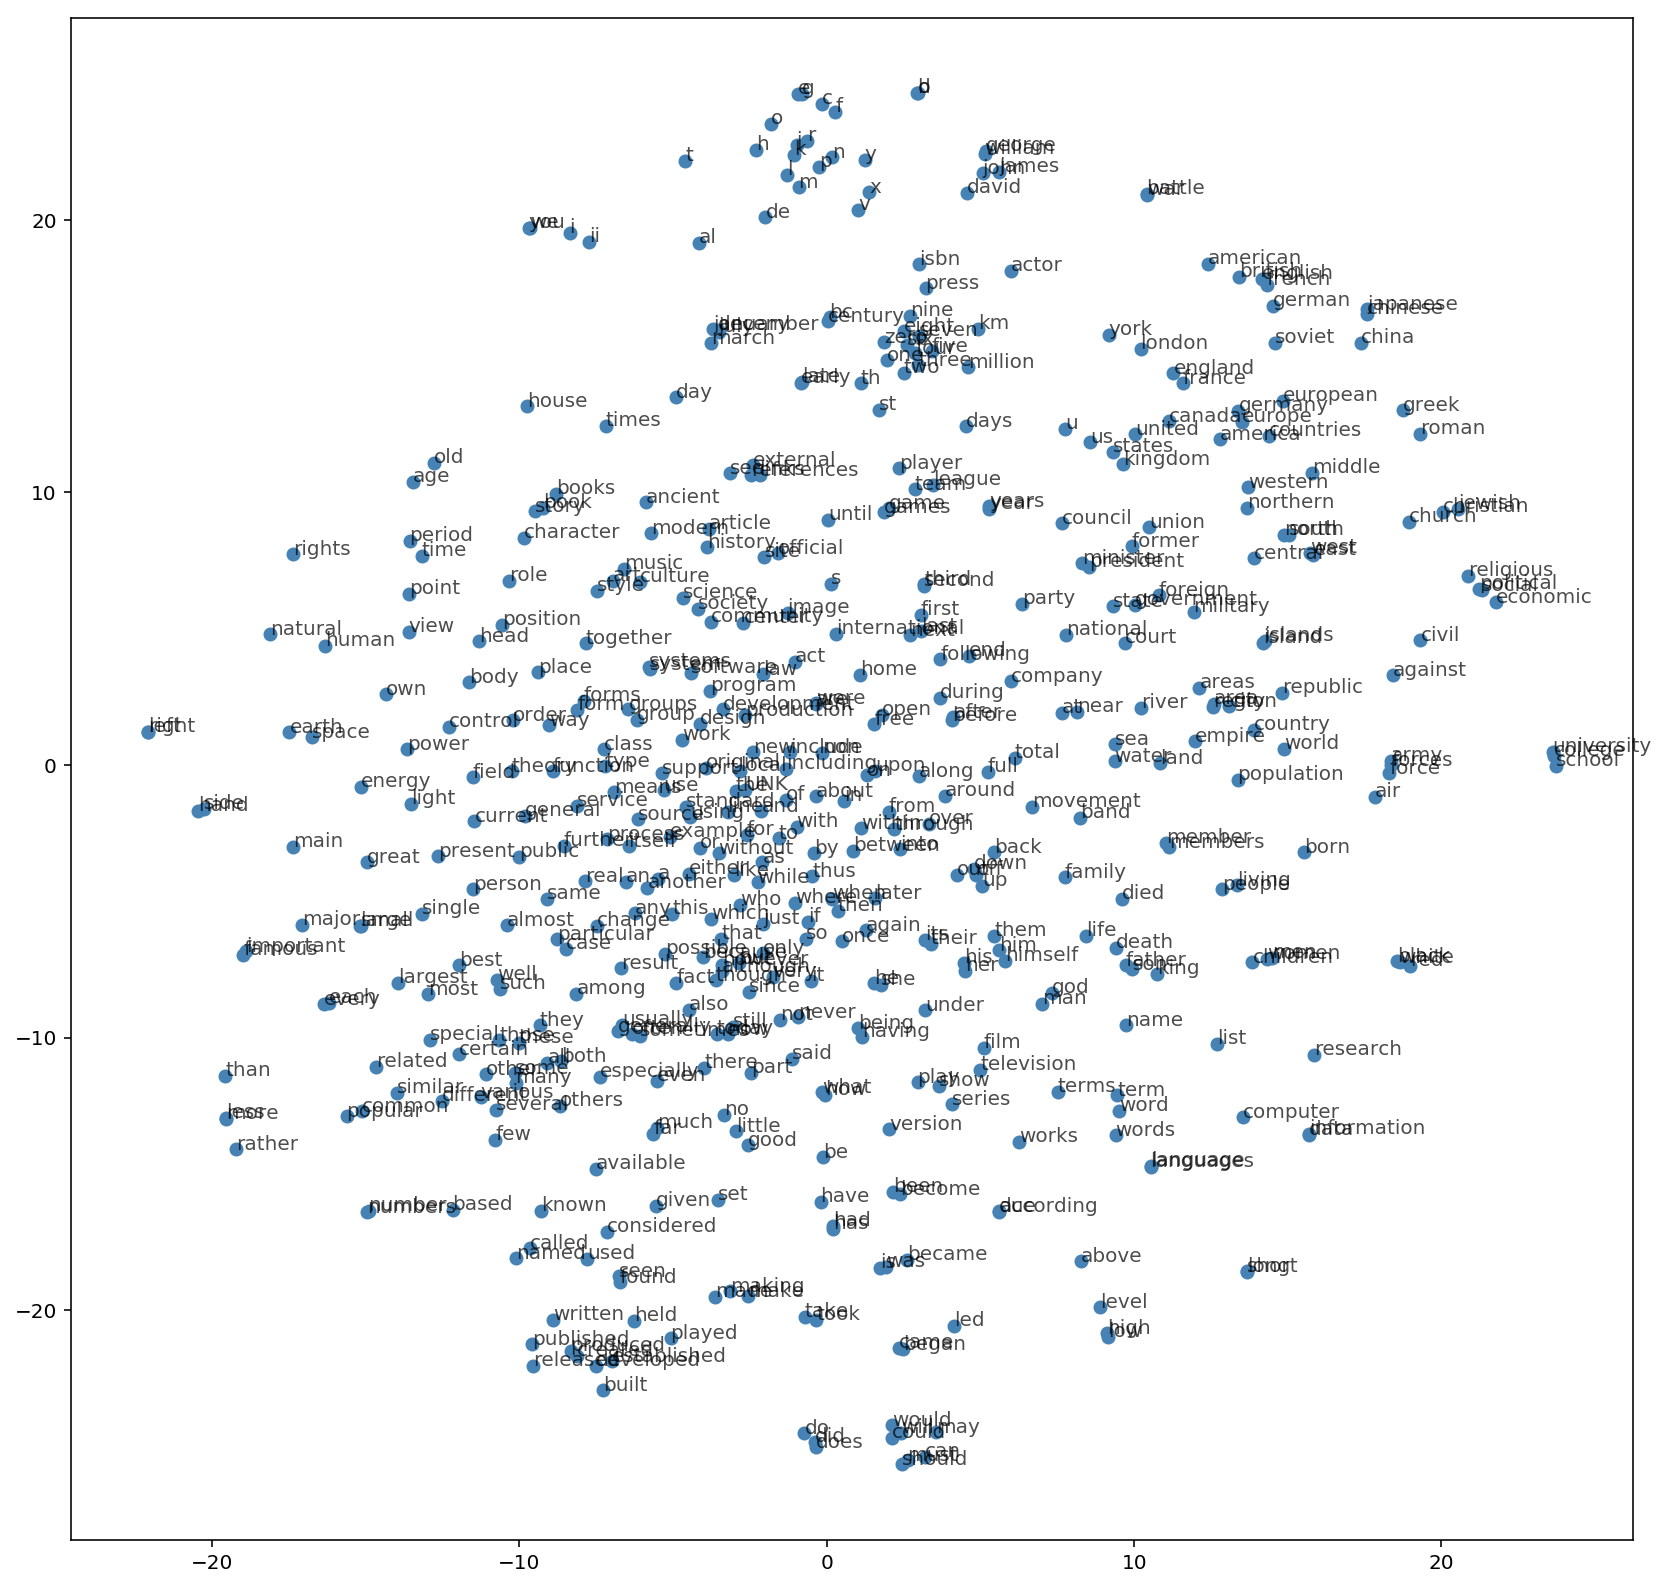

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(index_dictionary[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

In [20]:
from six.moves import xrange  # pylint: disable=redefined-builtin

top_k = 10
for word in ["word", "two", "vector", "machine", "learning"]:
    i = dictionary[word]
    nearest = (-embed_mat[i, :]).argsort()[1:top_k + 1]
    log_str = "Nearest to %s:" % word
    for k in xrange(top_k):
        close_word = index_dictionary[nearest[k]]
        log_str = "%s %s," % (log_str, close_word)
    print(log_str)


Nearest to word: american, into, people, is, will, any, had, three, up, nine,
Nearest to two: as, two, up, they, which, been, m, its, are, government,
Nearest to vector: united, only, d, about, being, out, one, into, known, to,
Nearest to machine: at, on, into, is, this, after, for, up, then, however,
Nearest to learning: into, so, which, d, there, the, this, nine, known, all,
